In [1]:
#meta: 6/10/2022 Ch 4. Intro to Autoregressive and Automated Methods
#book: Machine Learning for Time Series Forecasting with Python  
#author: Francesca Lazzeri, PhD.  
#forked from FrancescaLazzeri https://github.com/FrancescaLazzeri/Machine-Learning-for-Time-Series-Forecasting  

#infra: myLaptop MBPro
#env timeseriesbook: Python 3.7.9
#numpy 1.18.5, pandas 1.1.2, matplotlib 3.3.2 
#statsmodels 0.12.0

#history
# my work through code is marked with `$my`
#6/10/2022 ARIMA 1st DRAFT
#      created env timeseriesbook
#      AR, MA, ARMA, ARIMA and SARIMAX
#      stats plotting for fitting ts models: ACF, PACF
#      stats plotting for evaluationg ts models: plot_diagnostics()
#      ts forecasting w/ horizon
#      ts model evaluations
#next: review todo list and finish ARIMA part

In [2]:
#python version $my
import sys
print(sys.version)

3.7.9 (default, Aug 31 2020, 07:22:35) 
[Clang 10.0.0 ]


# Chapter 4 - Introduction to Autoregressive and Automated Methods for Time Series Forecasting
- `AR(p)` model makes predictions using previous values in the ts    
- `MA(q)` model makes predictions using using the ts mean and previous errors  
- `ARMA(p,q)` is a stationary model; works well with stationary ts (whose stat properties `mean`, `autocorrelation`, and `seasonality` don't depend on the time at which the series has been observed).  
- `ARIMA(p,d,q)` is a non-stationary model   $actodo finish


In [3]:
import datetime as dt
import os
import shutil
import warnings
from collections import UserDict
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from common.utils import load_data, mape
from IPython.display import Image

%matplotlib inline
plt.rc("figure", figsize=(10,6))

from sklearn.preprocessing import MinMaxScaler


In [4]:
#------ GLOBAL CONSTANTS and Variables ---------
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

pd.options.display.float_format = "{:,.2f}".format
#makes sure that `pandas` datatypes like `pd.Timestamp` can be used in `matplotlib` plots without having to cast them to another type
pd.plotting.register_matplotlib_converters() 

## 0. Load Data
Refer to my0_DataSetup.ipynb

In [5]:
data_dir = "./data"
ts_data_load = load_data(data_dir)[["load"]]

print(ts_data_load.shape)
print('Index type: ', ts_data_load.index.dtype, ts_data_load.index.__class__)
print(ts_data_load.dtypes)

#preview
ts_data_load.head()

(26304, 1)
Index type:  datetime64[ns] <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
load    float64
dtype: object


,load
2012-01-01 00:00:00,"2,698.00"
2012-01-01 01:00:00,"2,558.00"
2012-01-01 02:00:00,"2,444.00"
2012-01-01 03:00:00,"2,402.00"
2012-01-01 04:00:00,"2,403.00"


### 0.1 EDA

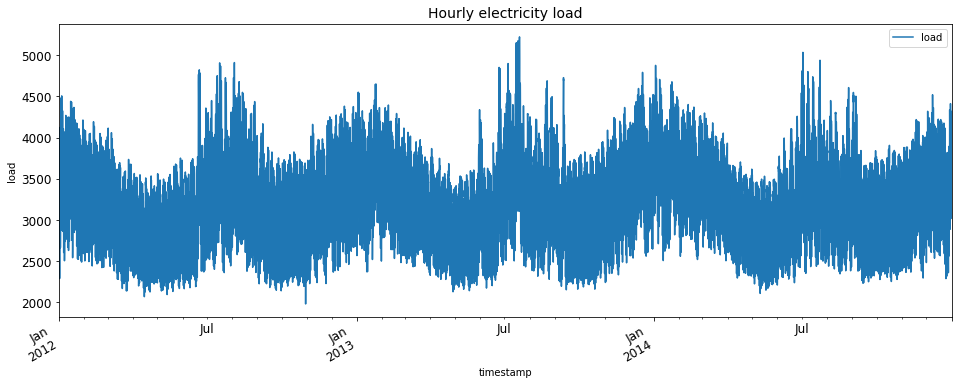

In [6]:
ts_data_load.plot(y='load', subplots=True, figsize=(16, 6), fontsize=12)
plt.title('Hourly electricity load', fontsize=14)
plt.xlabel('timestamp')
plt.ylabel('load')
plt.show()

##### Lag plot
Used to check if ts is random: random shouldn't exhibit any structure in the lag plot.

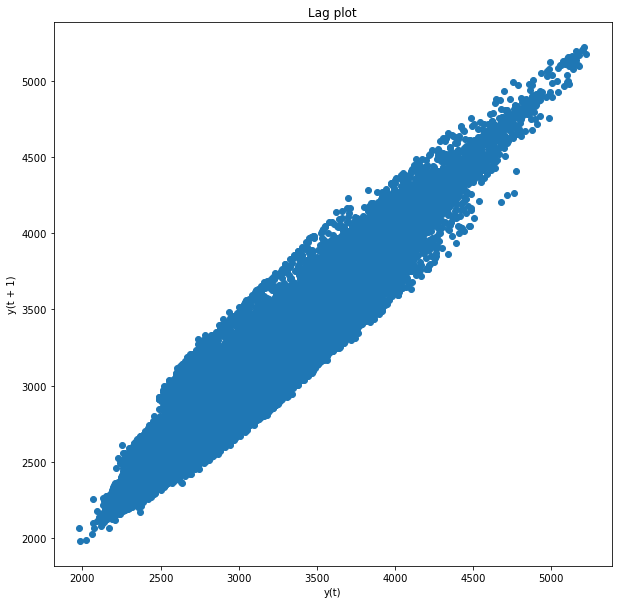

In [7]:
from pandas.plotting import lag_plot

plt.figure(figsize=(10, 10))
plt.title('Lag plot')
lag_plot(ts_data_load);

See a large concentration of values along a diagonal line of the plot. It clearly shows a relationship or some correlation between observations. 

##### Autocorrelation plot
Also used to check randomness in ts by computing autocorrelations at fluctuating time lags.  If ts is random, autocorr values should be near zero for all time lags. If ts is non-random, then one or more of the autocorr will be significantly non-zero.

The autocorrelation plot is intended to reveal whether the data points of a ts are positively correlated, negatively correlated or independent of each other.

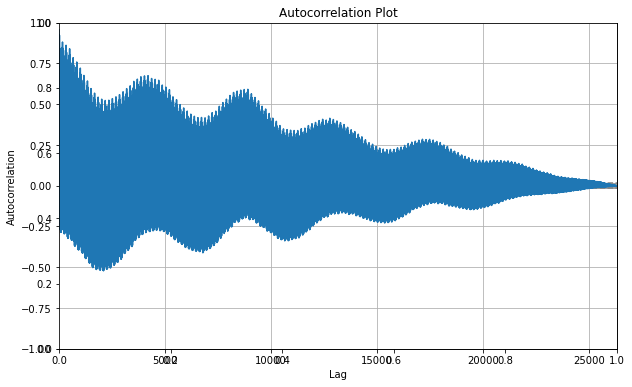

In [8]:
from pandas.plotting import autocorrelation_plot

#Autocorrelation Plot Results from ts_data_load dataset
#plt.figure(figsize=(10, 6))
plt.title('Autocorrelation Plot')
autocorrelation_plot(ts_data_load);

Ds is very granular (contains many hourly data points) -> not able to see horizontal lines that are supposed to be displayed. 

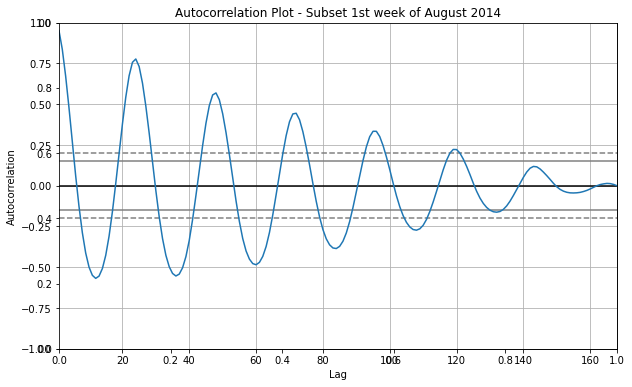

In [9]:
#Autocorrelation Plot Results from ts_data_load_subset (First week of August 2014)
ts_data_load_subset = ts_data_load["2014-08-01":"2014-08-07"]

plt.title('Autocorrelation Plot - Subset 1st week of August 2014')
autocorrelation_plot(ts_data_load_subset);

The horizontal lines in the plot correspond to 95% and 99% confidence bands.  
The dashed line is 99% confidence band.

##### Autocorrelation function (acf) plot on ts_data_load dataset
A plot of the autocorr of a ts by lag: x-axis shows lag values, y-axis shows the correlation between -1 and 1. 

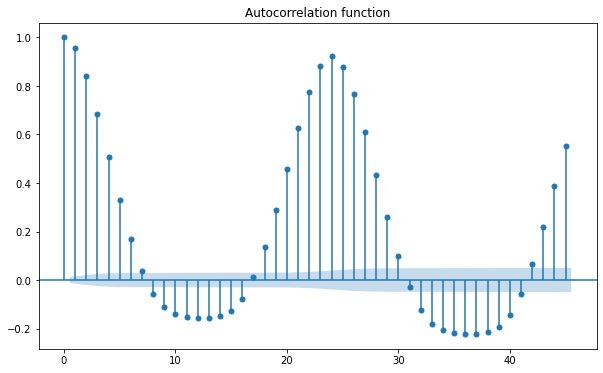

In [10]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ts_data_load, title = 'Autocorrelation function')
plt.show()

### Autocorrelation function (acf) plot on ts_data_load subset

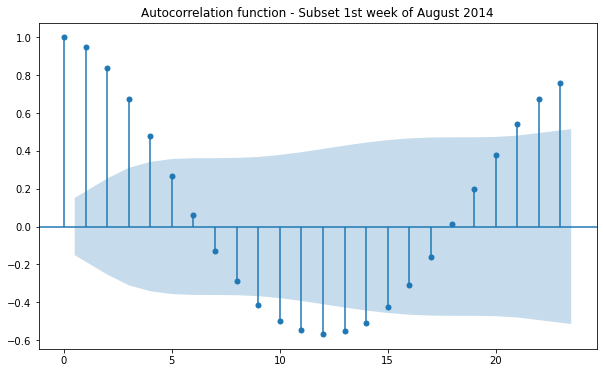

In [11]:
plot_acf(ts_data_load_subset, title = 'Autocorrelation function - Subset 1st week of August 2014')
plt.show()

By default, confidence intervals for ACF are set to a 95%, suggesting that corr values outside are very likely a correlation.

##### Partial correlation function (pacf) plot on ts_data_load dataset
a conditional correlation - it's the corr between 2 vars 

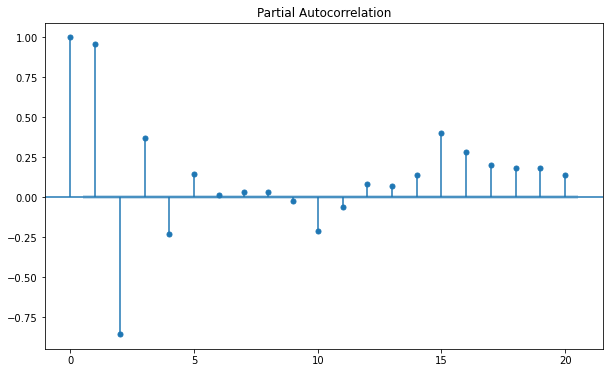

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(ts_data_load, lags=20)
plt.show()

### Partial correlation function (pacf) plot on ts_data_load subset

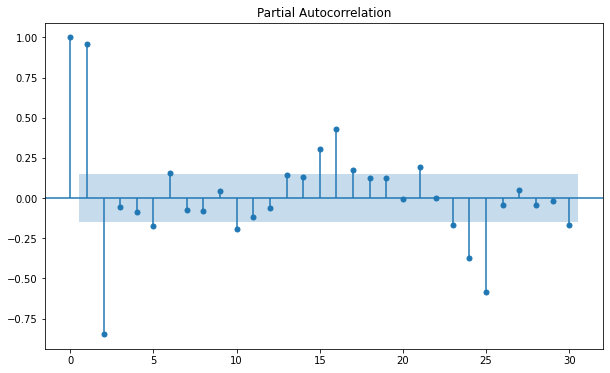

In [13]:
plot_pacf(ts_data_load_subset, lags=30)
plt.show()

ACF provides info of how much a series is autocorrelated with its lagged values = describes how well the present value of the series is related with its past values.

PACF finds corr of the residuals with the next lag.  It's a fn that measures the incremental benefit of adding another lag

$actodo: pg 109 and 110 ok from page 116

## Autoregressive method class in Statsmodels

In [15]:
from statsmodels.tsa.ar_model import AutoReg

In [16]:
model = AutoReg(ts_data_load['load'], 1) #class statsmodels.tsa.ar_model.AutoReg
results = model.fit() #class statsmodels.tsa.ar_model.AutoRegResultsWrapper
print(results.summary())

                            AutoReg Model Results                             
Dep. Variable:                   load   No. Observations:                26304
Model:                     AutoReg(1)   Log Likelihood             -171639.978
Method:               Conditional MLE   S.D. of innovations            165.100
Date:                Wed, 15 Jun 2022   AIC                             10.213
Time:                        19:59:56   BIC                             10.214
Sample:                    01-01-2012   HQIC                            10.214
                         - 12-31-2014                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    144.5181      6.043     23.913      0.000     132.673     156.363
load.L1        0.9563      0.002    530.344      0.000       0.953       0.960
                                    Roots           

#### Note: AutoReg supports describing the same covariance estimators as OLS. Below, we use cov_type="HC0", which is White’s covariance estimator. While the parameter estimates are the same, all of the quantities that depend on the standard error change.

In [17]:
res = model.fit(cov_type="HC0")
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                   load   No. Observations:                26304
Model:                     AutoReg(1)   Log Likelihood             -171639.978
Method:               Conditional MLE   S.D. of innovations            165.100
Date:                Wed, 15 Jun 2022   AIC                             10.213
Time:                        19:59:56   BIC                             10.214
Sample:                    01-01-2012   HQIC                            10.214
                         - 12-31-2014                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    144.5181      5.364     26.945      0.000     134.006     155.030
load.L1        0.9563      0.002    618.131      0.000       0.953       0.959
                                    Roots           

##### `plot_predict()`
can visualize the forecasts: a large number of forecasts that show seasonality captured by the model

No handles with labels found to put in legend.


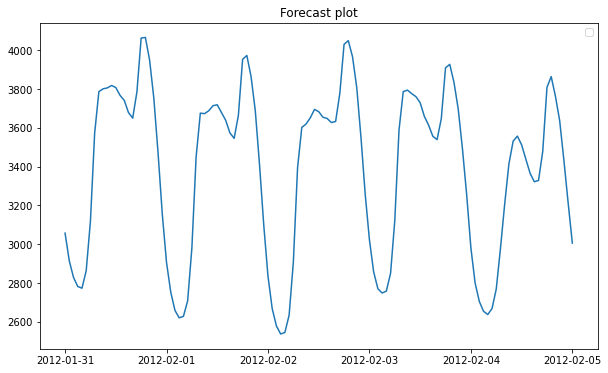

In [18]:
fig = res.plot_predict(720, 840)
plt.title('Forecast plot');

##### `plot_diagnostics()`
indicates that the model captures the key features in the data

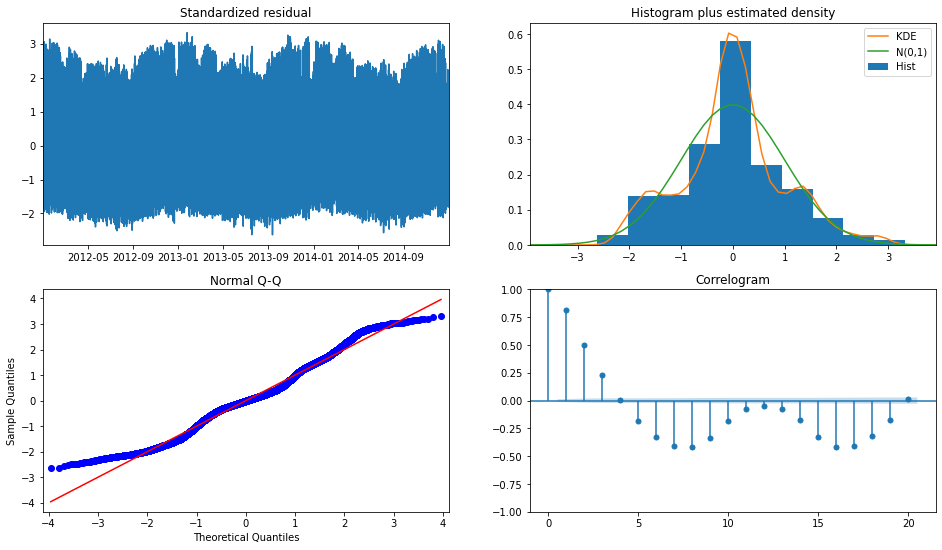

In [19]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=20)
fig;

### Prepare the ts_data_load dataset for forecasting task with AutoReg() function
Test the forecasting capability of the `AutoReg()`: produced with `predict` method from a results instance.  
- one-step forecasts by default  
- multi-step forecasts `dynamic = True`

In [20]:
#train test split
train_start_dt = "2014-11-01 00:00:00"
test_start_dt = "2014-12-30 00:00:00"

train = ts_data_load.copy()[
    (ts_data_load.index >= train_start_dt) & (ts_data_load.index < test_start_dt)
][["load"]]
test = ts_data_load.copy()[ts_data_load.index >= test_start_dt][["load"]]

print("Training data shape: ", train.shape)
print("Test data shape: ", test.shape)

Training data shape:  (1416, 1)
Test data shape:  (48, 1)


In [21]:
#scale ts (values fall within (0,1))
scaler = MinMaxScaler()
train["load"] = scaler.fit_transform(train)
print(train['load'].min(), train['load'].max())
train.head()

0.0 0.9999999999999998


,load
2014-11-01 00:00:00,0.10
2014-11-01 01:00:00,0.07
2014-11-01 02:00:00,0.05
2014-11-01 03:00:00,0.04
2014-11-01 04:00:00,0.06


In [22]:
test["load"] = scaler.transform(test)
print(test['load'].min(), test['load'].max())
test.head()

0.26812891674127126 0.9516562220232765


,load
2014-12-30 00:00:00,0.33
2014-12-30 01:00:00,0.29
2014-12-30 02:00:00,0.27
2014-12-30 03:00:00,0.27
2014-12-30 04:00:00,0.30


In [23]:
#specify # of steps to forecast ahead
HORIZON = 3
print("Forecasting horizon:", HORIZON, "hours")

Forecasting horizon: 3 hours


handy `pandas.Series.shift`    
refer to https://pandas.pydata.org/docs/reference/api/pandas.Series.shift.html

In [24]:
#create a test data point for each horizon
test_shifted = test.copy()

for t in range(1, HORIZON):
    test_shifted["load+" + str(t)] = test_shifted["load"].shift(-t, freq="H")

test_shifted = test_shifted.dropna(how="any")
print(test.shape, test_shifted.shape)

#$my preview original test vs created test_shifted
print('\noriginal test: \n', test.head(7))
print('\ntest w/ horizon: \n', test_shifted.head(5))

(48, 1) (46, 3)

original test: 
                      load
2014-12-30 00:00:00  0.33
2014-12-30 01:00:00  0.29
2014-12-30 02:00:00  0.27
2014-12-30 03:00:00  0.27
2014-12-30 04:00:00  0.30
2014-12-30 05:00:00  0.41
2014-12-30 06:00:00  0.57

test w/ horizon: 
                      load  load+1  load+2
2014-12-30 00:00:00  0.33    0.29    0.27
2014-12-30 01:00:00  0.29    0.27    0.27
2014-12-30 02:00:00  0.27    0.27    0.30
2014-12-30 03:00:00  0.27    0.30    0.41
2014-12-30 04:00:00  0.30    0.41    0.57


##### Build Autoregression Forecasts with TimeSeries Data
Use `forecast` (not `predict`) method to make predictions on the test data

In [25]:
%%time
training_window = 720

train_ts = train["load"]
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = list()

for t in range(test_ts.shape[0]):
    model = AutoReg(history, 1)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps=HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t + 1, ": predicted =", yhat, "expected =", obs)

2014-12-30 00:00:00
1 : predicted = [0.42 0.42 0.43] expected = [0.32945389435989236, 0.2900626678603402, 0.2739480752014323]
2014-12-30 01:00:00
2 : predicted = [0.34 0.35 0.36] expected = [0.2900626678603402, 0.2739480752014323, 0.26812891674127126]
2014-12-30 02:00:00
3 : predicted = [0.3  0.31 0.33] expected = [0.2739480752014323, 0.26812891674127126, 0.3025962399283795]
2014-12-30 03:00:00
4 : predicted = [0.29 0.3  0.31] expected = [0.26812891674127126, 0.3025962399283795, 0.40823634735899716]
2014-12-30 04:00:00
5 : predicted = [0.28 0.3  0.31] expected = [0.3025962399283795, 0.40823634735899716, 0.5689346463742166]
2014-12-30 05:00:00
6 : predicted = [0.31 0.33 0.34] expected = [0.40823634735899716, 0.5689346463742166, 0.6799462846911368]
2014-12-30 06:00:00
7 : predicted = [0.41 0.42 0.43] expected = [0.5689346463742166, 0.6799462846911368, 0.7309758281110115]
2014-12-30 07:00:00
8 : predicted = [0.57 0.56 0.56] expected = [0.6799462846911368, 0.7309758281110115, 0.75111906893

##### Extra
myMini

In [26]:
#$my mini w/my comments
history = [x for x in train_ts]
#train on last n =training_window points
history = history[(-training_window):]

my_predictions = list()

for t in range(2):
    model = AutoReg(history, 1)
    model_fit = model.fit()
    
    #forecast 3 steps ahead
    yhat = model_fit.forecast(steps=HORIZON)   
    my_predictions.append(yhat)
    
    #manage history to train on most recent data
    obs = list(test_ts.iloc[t])
    history.append(obs[0])
    history.pop(0)
    
    #display predicted yhat vs expected (next 3 actual observations) 
    print(test_ts.index[t])
    print(t + 1, ": predicted =", yhat, "expected =", obs)

2014-12-30 00:00:00
1 : predicted = [0.42 0.42 0.43] expected = [0.32945389435989236, 0.2900626678603402, 0.2739480752014323]
2014-12-30 01:00:00
2 : predicted = [0.34 0.35 0.36] expected = [0.2900626678603402, 0.2739480752014323, 0.26812891674127126]


720 46


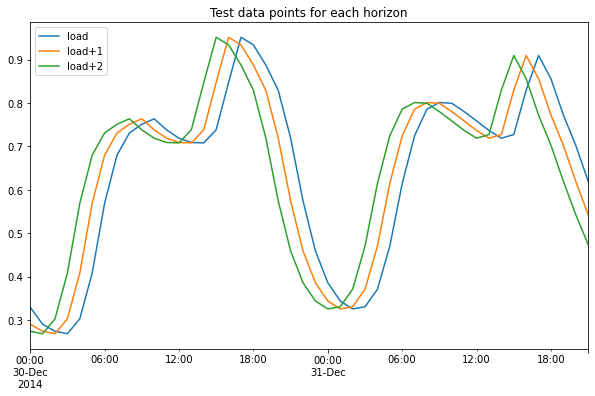

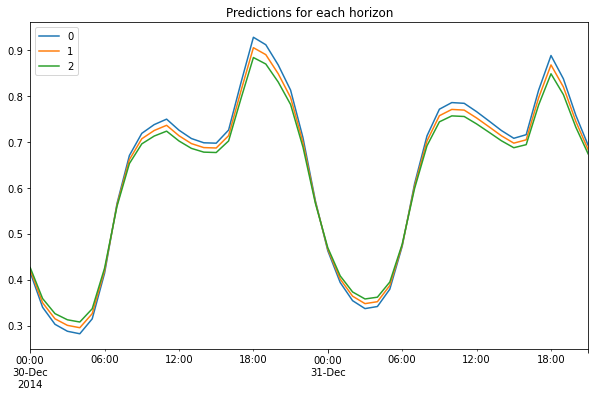

In [27]:
#$myVis - test data vs predictions
print(len(history), len(predictions))

test_shifted.plot(title="Test data points for each horizon")

df_yhat = pd.DataFrame(predictions, test_shifted.index)
df_yhat.plot(title="Predictions for each horizon");

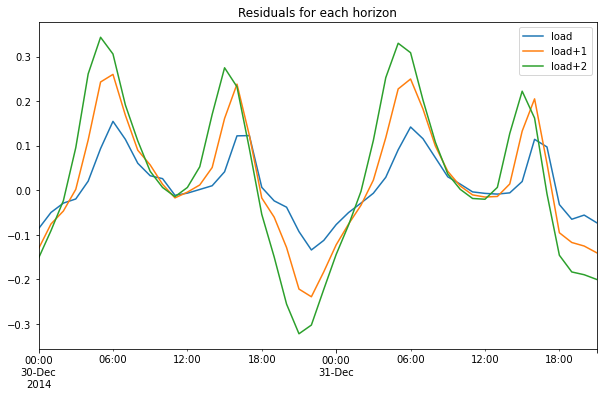

In [28]:
#$myVis residuals
df_residuals = test_shifted - df_yhat.values
df_residuals.plot(title="Residuals for each horizon");

Residuals plot suggests forecasts are better for the closest horizon.

## Moving Average 
MA technique leverages previous forecast errors in a regression approach to forecast future observations: each future observation can be thought of as a weighted MA of the previous forecast errors.  

MA models are very similar to AR models:  
- AR models represent a linear combination of past observations  
- MA models represent a linear combination of past error terms  

MA are good at explaining hidden and irregular patterns in the error process directly by fitting a model to the error terms. 

##### in Statsmodels
`statsmodels.tsa.arima_model.ARMA`  `order=(0,q)`  
https://www.statsmodels.org/0.8.0/generated/statsmodels.tsa.arima_model.ARMA.html

https://www.statsmodels.org/0.8.0/generated/statsmodels.tsa.arima_model.ARMA.fit.html#statsmodels.tsa.arima_model.ARMA.fit

https://www.statsmodels.org/0.8.0/generated/statsmodels.tsa.arima_model.ARMAResults.html#statsmodels.tsa.arima_model.ARMAResults


In [29]:
from statsmodels.tsa.arima_model import ARMA

model_mov_avg = ARMA(ts_data_load_subset, order=(0,1))
#results = model_mov_avg.fit()
#to hide convergence information
results = model_mov_avg.fit(disp=0)
print(results.summary())

                              ARMA Model Results                              
Dep. Variable:                   load   No. Observations:                  168
Model:                     ARMA(0, 1)   Log Likelihood               -1196.863
Method:                       css-mle   S.D. of innovations            295.887
Date:                Wed, 15 Jun 2022   AIC                           2399.726
Time:                        19:59:58   BIC                           2409.098
Sample:                    08-01-2014   HQIC                          2403.529
                         - 08-07-2014                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3470.6911     45.522     76.242      0.000    3381.470    3559.912
ma.L1.load     1.0000      0.020     50.666      0.000       0.961       1.039
                                    Roots           

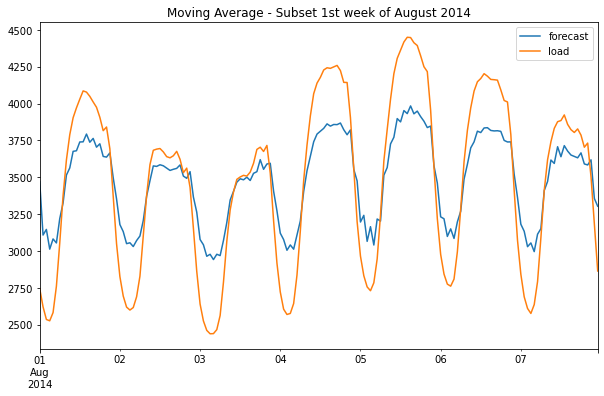

In [30]:
#$myVis $todo
fig = results.plot_predict()
plt.title('Moving Average - Subset 1st week of August 2014');

$note:  
tried `ARMA(ts_data_load_subset, order=(0,2))`   
get  `ValueError`: The computed initial MA coefficients are not invertible You should induce invertibility, choose a different model order, or you can pass your own start_params.

## Autoregressive Moving Average 
An ARMA model consists of two parts: AR and MA model. Compared with AR and MA models, ARMA models provide the most efficient linear model of stationary ts, since they're capable of modeling the uknown process with the min number of params. In particular, ARMA models are used to describe weekly stationary stochastic ts in terms of two polynomials:  
1. `p` the order of the AR polynomial  
2. `q` the order of the MA polynomial 

Fit ts models to data based on insights gathered from the `ACF` and `PACF.

##### in Statsmodels
`statsmodels.tsa.arima_model.ARMA`  `order=(p,q)`    


## Autoregressive Integrated Moving Average method in Statsmodels
The main diff between ARMA and ARIMA methods are the notions of integration and differencing.  ARMA is stationary.  ARIMA works with non-stationary ts. It's possible to stationarize a ts through differencing techniques, ie. `Xt - X(t-1)`.  The process of estimating how many nonseasonal difference are needed to make a ts stationary is called integration `I` or integrated method.  ARIMA models have 3 main components:  
- `p` the lag order  
- `d` the degree of differencing (# of times the raw values are differenced  
- `q` the order of MA (magnitude of the MA window)  

##### SARISMAX
Seasonal autoregressive integrated moving average with exogenous factores -  an extenstion of the ARIMA model. Apply SARISMAX when deal with ts that have seasonal cycles.

##### in Statsmodels
`statsmodels.tsa.statespace.sarimax.SARISMAX`  `order=(p,d,q)` `seasonal_order=(p,d,q,s)`  
- `s` periodicity (# of periods in season; often 4 for quarterly data or 12 for monthly data)

##### Apply a SARISMAX model
Since this is a daily consumption of energy, there's a strong seasonal pattern, but the consumption is most similar to consumptions in the recent days -> using a relatively small window for training should be sufficient.

In [31]:
import math
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Prepare the ts_data_load dataset for forecasting task with SARISMAX model
(same as above)


In [42]:
data_dir = "./data"
ts_data_load = load_data(data_dir)[["load"]]
ts_data_load.head(10)

#train test split
train_start_dt = "2014-11-01 00:00:00"
test_start_dt = "2014-12-30 00:00:00"

train = ts_data_load.copy()[
    (ts_data_load.index >= train_start_dt) & (ts_data_load.index < test_start_dt)
][["load"]]
test = ts_data_load.copy()[ts_data_load.index >= test_start_dt][["load"]]

print("Training data shape: ", train.shape)
print("Test data shape: ", test.shape)

#scale
scaler = MinMaxScaler()
train["load"] = scaler.fit_transform(train)
train.head()

test["load"] = scaler.transform(test)
test.head()

#specify # of steps to forecast ahead
HORIZON = 3
print("Forecasting horizon:", HORIZON, "hours")


#create a test data point for each horizon
test_shifted = test.copy()

for t in range(1, HORIZON):
    test_shifted["load+" + str(t)] = test_shifted["load"].shift(-t, freq="H")

test_shifted = test_shifted.dropna(how="any")
test_shifted.head(5)

Training data shape:  (1416, 1)
Test data shape:  (48, 1)
Forecasting horizon: 3 hours


,load,load+1,load+2
2014-12-30 00:00:00,0.33,0.29,0.27
2014-12-30 01:00:00,0.29,0.27,0.27
2014-12-30 02:00:00,0.27,0.27,0.30
2014-12-30 03:00:00,0.27,0.30,0.41
2014-12-30 04:00:00,0.30,0.41,0.57


##### myVis
EDA train ds before modeling

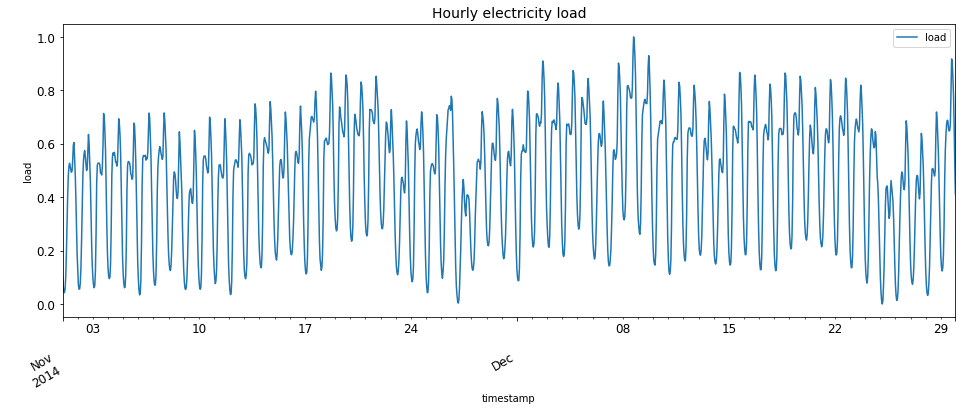

In [43]:
train.plot(y='load', subplots=True, figsize=(16, 6), fontsize=12)
plt.title('Hourly electricity load', fontsize=14)
plt.xlabel('timestamp')
plt.ylabel('load')
plt.show()

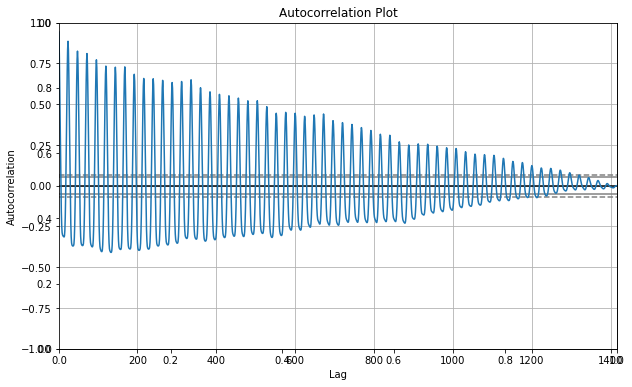

In [44]:
#Autocorrelation Plot Results from ts_data_load dataset
plt.title('Autocorrelation Plot')
autocorrelation_plot(train);

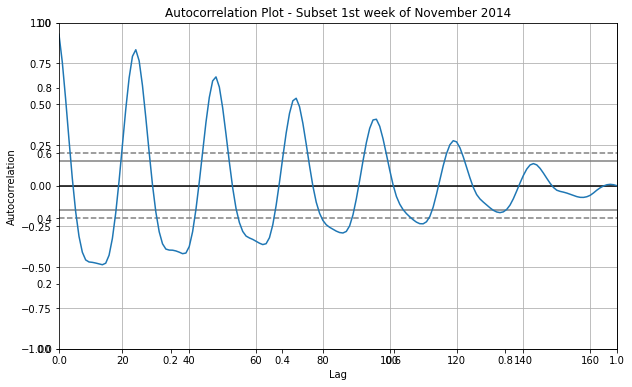

In [47]:
#Autocorrelation Plot Results from ts_data_load_subset (First week of August 2014)
train_subset = train["2014-11-01":"2014-11-07"]

plt.title('Autocorrelation Plot - Subset 1st week of November 2014')
autocorrelation_plot(train_subset);

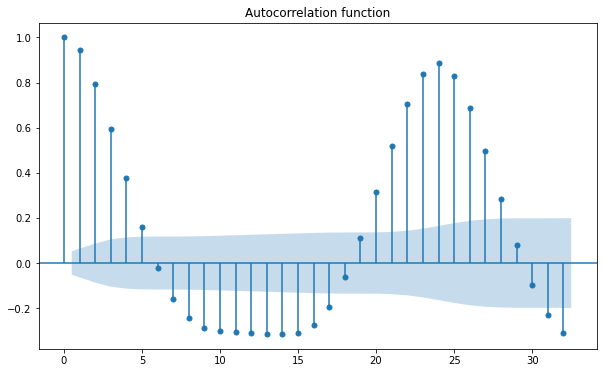

In [48]:
plot_acf(train, title = 'Autocorrelation function')
plt.show()

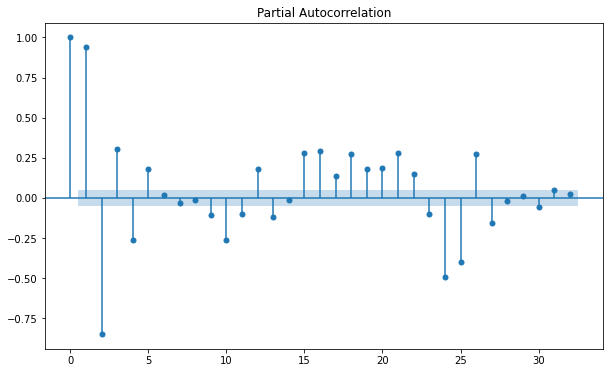

In [49]:
plot_pacf(train)
plt.show()

In [33]:
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 24)

In [34]:
model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order) #class statsmodels.tsa.statespace.sarimax.SARIMAX
results = model.fit() #class statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper

print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.45318D+00    |proj g|=  2.50788D+00


 This problem is unconstrained.



At iterate    5    f= -2.45391D+00    |proj g|=  4.80689D-01

At iterate   10    f= -2.45558D+00    |proj g|=  8.67424D-01

At iterate   15    f= -2.45565D+00    |proj g|=  6.64118D-03

At iterate   20    f= -2.45566D+00    |proj g|=  2.64276D-01

At iterate   25    f= -2.45567D+00    |proj g|=  1.34960D-02

At iterate   30    f= -2.45568D+00    |proj g|=  1.40543D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     58      1     0     0   1.405D-03  -2.456D+00
  F =  -2.4556764231530024     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                 1416
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 24)   Log Likelihood                3477.238
Date:                            Wed, 15 Jun 2022   AIC                          -6942.476
Time:                                    20:00:06   BIC                          -6911.049
Sample:                                11-01-2014   HQIC                         -6930.724
                                     - 12-29-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8399      0.016     52.248      0.000       0.808       0.871
ar.L2         -0.5210      0.034   

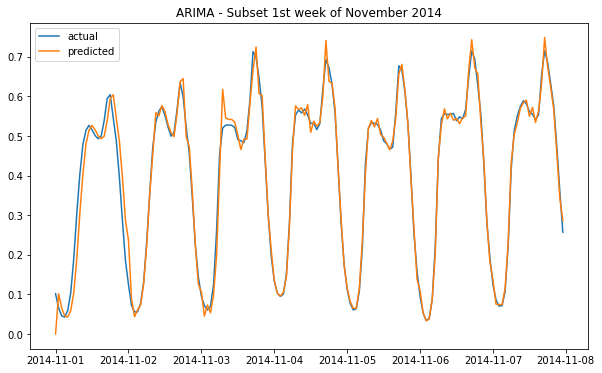

In [71]:
#$myVis $todo? 
plt.plot(train_subset, label='actual')
plt.plot(results.predict("2014-11-01","2014-11-07"), label='predicted')
plt.title('ARIMA - Subset 1st week of November 2014');
plt.legend()


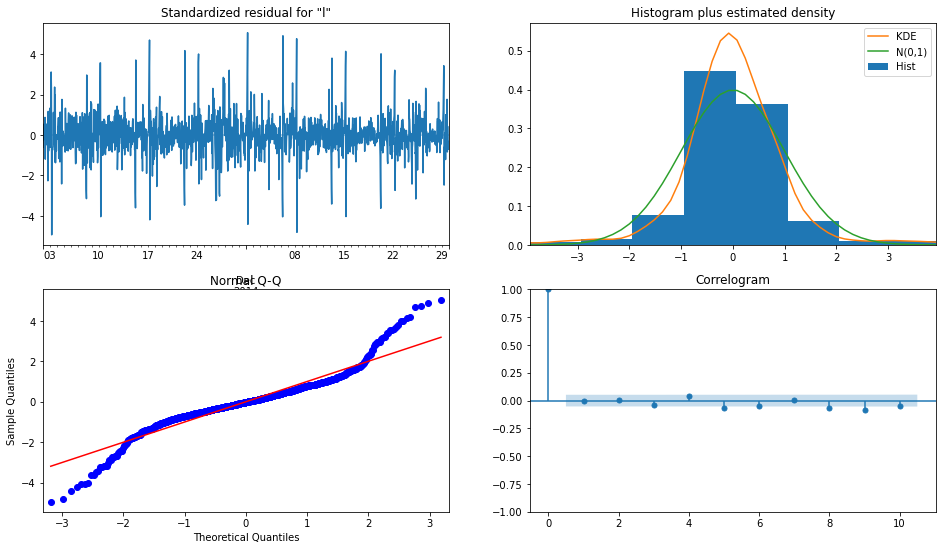

In [51]:
#$myVis - plot_diagnostics()
fig = plt.figure(figsize=(16, 9))
fig = results.plot_diagnostics(fig=fig) #, lags=20
fig;

$actodo Model diagnostics show the model could use more revising, especially `I` part?

$actodo pg.126 done but revisit

In [52]:
%%time
training_window = 720

train_ts = train["load"]
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = list()

order = (2, 1, 0)
seasonal_order = (1, 1, 0, 24)

for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps=HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t + 1, ": predicted =", yhat, "expected =", obs)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.41942D+00    |proj g|=  1.50341D+00


 This problem is unconstrained.



At iterate    5    f= -2.41973D+00    |proj g|=  5.41394D-01

At iterate   10    f= -2.42221D+00    |proj g|=  1.24200D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f= -2.42274D+00    |proj g|=  1.00853D-01

At iterate   20    f= -2.42274D+00    |proj g|=  2.94418D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f= -2.42282D+00    |proj g|=  9.79754D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-2.196E-12  -gs= 4.589E-12 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28    140      5     1     0   1.113D-02  -2.423D+00
  F =  -2.4228244949672906     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after 20 function
  and gradient evaluations.  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/amigopro/opt/anaconda3/envs/timeseriesbook/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


2014-12-30 00:00:00
1 : predicted = [0.32 0.29 0.28] expected = [0.32945389435989236, 0.2900626678603402, 0.2739480752014323]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.41939D+00    |proj g|=  1.51571D+00


 This problem is unconstrained.



At iterate    5    f= -2.41975D+00    |proj g|=  1.12162D-01

At iterate   10    f= -2.42272D+00    |proj g|=  2.72971D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     35      1     0     0   2.015D-01  -2.423D+00
  F =  -2.4227306897105336     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2014-12-30 01:00:00
2 : predicted = [0.3  0.29 0.3 ] expected = [0.2900626678603402, 0.2739480752014323, 0.26812891674127126]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.42057D+00    |proj g|=  1.40865D+00


 This problem is unconstrained.



At iterate    5    f= -2.42084D+00    |proj g|=  4.40378D-01

At iterate   10    f= -2.42364D+00    |proj g|=  4.38863D-01
  ys=-2.331E-09  -gs= 8.360E-10 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f= -2.42365D+00    |proj g|=  2.76294D-02

At iterate   20    f= -2.42366D+00    |proj g|=  2.29237D-01

At iterate   25    f= -2.42389D+00    |proj g|=  2.46764D-01

At iterate   30    f= -2.42390D+00    |proj g|=  6.04146D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34    118      3     1     0   1.344D-02  -2.424D+00
  F =  -2.4238974965630251     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 02:00:00
3 : predicted = [0.27 0.28 0.32] expected = [0.2739480752014323, 0.26812891674127126, 0.3025962399283795]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.42198D+00    |proj g|=  8.36871D-01


 This problem is unconstrained.



At iterate    5    f= -2.42212D+00    |proj g|=  1.12460D+00

At iterate   10    f= -2.42531D+00    |proj g|=  7.68335D-01

At iterate   15    f= -2.42537D+00    |proj g|=  2.23457D-02

At iterate   20    f= -2.42544D+00    |proj g|=  1.22282D-01

At iterate   25    f= -2.42547D+00    |proj g|=  3.69450D-02

At iterate   30    f= -2.42549D+00    |proj g|=  4.87801D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f= -2.42550D+00    |proj g|=  1.81123D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-1.863E-10  -gs= 1.464E-09 BFGS update SKIPPED


/Users/amigopro/opt/anaconda3/envs/timeseriesbook/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)

 Line search cannot locate an adequate point after 20 function
  and gradient evaluations.  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39    130      4     1     0   1.413D-02  -2.425D+00
  F =  -2.4254953754183366     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2014-12-30 03:00:00
4 : predicted = [0.28 0.32 0.42] expected = [0.26812891674127126, 0.3025962399283795, 0.40823634735899716]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.42388D+00    |proj g|=  1.06644D+00


 This problem is unconstrained.



At iterate    5    f= -2.42409D+00    |proj g|=  8.11257D-01

At iterate   10    f= -2.42805D+00    |proj g|=  2.84783D-01

At iterate   15    f= -2.42807D+00    |proj g|=  2.77473D-02

At iterate   20    f= -2.42808D+00    |proj g|=  1.59404D-01

At iterate   25    f= -2.42829D+00    |proj g|=  5.39502D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f= -2.42829D+00    |proj g|=  1.01837D-02

At iterate   35    f= -2.42832D+00    |proj g|=  1.76029D-01

At iterate   40    f= -2.42833D+00    |proj g|=  1.30644D-02
  ys=-2.897E-14  -gs= 4.604E-12 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/amigopro/opt/anaconda3/envs/timeseriesbook/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)

 Line search cannot locate an adequate point after 20 function
  and gradient evaluations.  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     41    155      3     1     0   1.306D-02  -2.428D+00
  F =  -2.4283256904637964     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2014-12-30 04:00:00
5 : predicted = [0.3  0.39 0.54] expected = [0.3025962399283795, 0.40823634735899716, 0.5689346463742166]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.42722D+00    |proj g|=  2.23014D+00


 This problem is unconstrained.



At iterate    5    f= -2.42777D+00    |proj g|=  8.50942D-01

At iterate   10    f= -2.43171D+00    |proj g|=  1.06779D+00

At iterate   15    f= -2.43183D+00    |proj g|=  1.38159D-02

At iterate   20    f= -2.43190D+00    |proj g|=  1.29705D-01

At iterate   25    f= -2.43201D+00    |proj g|=  6.46253D-02

At iterate   30    f= -2.43201D+00    |proj g|=  8.86168D-02

At iterate   35    f= -2.43204D+00    |proj g|=  1.18688D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     58      1     0     0   9.687D-03  -2.432D+00
  F =  -2.4320397494943156     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -2.45313D+00    |proj g|=  8.76462D-01

At iterate   10    f= -2.45592D+00    |proj g|=  4.47503D-01

At iterate   15    f= -2.45594D+00    |proj g|=  1.26598D-02

At iterate   20    f= -2.45596D+00    |proj g|=  1.08929D-01

At iterate   25    f= -2.45603D+00    |proj g|=  1.18986D-02

At iterate   30    f= -2.45606D+00    |proj g|=  1.29552D-02

At iterate   35    f= -2.45607D+00    |proj g|=  3.51506D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     51      1     0     0   3.515D-02  -2.456D+00
  F =  -2.4560652672761027     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -2.45832D+00    |proj g|=  7.32754D-01

At iterate   10    f= -2.46102D+00    |proj g|=  1.21150D+00

At iterate   15    f= -2.46116D+00    |proj g|=  1.42844D-01

At iterate   20    f= -2.46125D+00    |proj g|=  1.49564D-01

At iterate   25    f= -2.46128D+00    |proj g|=  1.51532D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     38      1     0     0   3.502D-03  -2.461D+00
  F =  -2.4612764200381783     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 07:00:00
8 : predicted = [0.68 0.75 0.8 ] expected = [0.6799462846911368, 0.7309758281110115, 0.751119

 This problem is unconstrained.



At iterate    5    f= -2.46223D+00    |proj g|=  3.35365D-01

At iterate   10    f= -2.46467D+00    |proj g|=  8.57243D-02

At iterate   15    f= -2.46468D+00    |proj g|=  2.48651D-01

At iterate   20    f= -2.46477D+00    |proj g|=  1.35535D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     83      2     0     0   3.037D-02  -2.465D+00
  F =  -2.4647700944835669     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2014-12-30 08:00:00
9 : predicted = [0.75 0.8  0.82] expected = [0.7309758281110115, 0.7511190689346463, 0.7636526410026856]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47439D+00    |proj g|=  2.05841D+00


 This problem is unconstrained.



At iterate    5    f= -2.47481D+00    |proj g|=  3.87015D-01

At iterate   10    f= -2.47689D+00    |proj g|=  1.87197D-01

At iterate   15    f= -2.47695D+00    |proj g|=  2.08027D-02

At iterate   20    f= -2.47696D+00    |proj g|=  3.77267D-02
  ys=-7.083E-07  -gs= 2.757E-07 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     64      1     1     0   6.229D-02  -2.477D+00
  F =  -2.4769560468033456     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2014-12-30 09:00:00
10 : predicted = [0.76 0.78 0.78] expected = [0.7511190689346463, 0.7636526410026856, 0.7381378692927483]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47407D+00    |proj g|=  1.97382D+00


 This problem is unconstrained.



At iterate    5    f= -2.47448D+00    |proj g|=  8.05814D-01

At iterate   10    f= -2.47668D+00    |proj g|=  2.44116D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     23      1     0     0   5.908D-02  -2.477D+00
  F =  -2.4766842463728800     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 10:00:00
11 : predicted = [0.76 0.75 0.74] expected = [0.7636526410026856, 0.7381378692927483, 0.7188898836168307]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At it

 This problem is unconstrained.



At iterate    5    f= -2.47465D+00    |proj g|=  4.22138D-01

At iterate   10    f= -2.47675D+00    |proj g|=  1.27309D+00

At iterate   15    f= -2.47696D+00    |proj g|=  8.43552D-02

At iterate   20    f= -2.47698D+00    |proj g|=  7.90021D-02

At iterate   25    f= -2.47699D+00    |proj g|=  3.86168D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     50      1     0     0   2.234D-03  -2.477D+00
  F =  -2.4769868881010901     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 11:00:00
12 : predicted = [0.77 0.76 0.75] expected = [0.7381378692927483, 0.7188898836168307, 0.70904

 This problem is unconstrained.



At iterate    5    f= -2.47302D+00    |proj g|=  3.73010D-01

At iterate   10    f= -2.47526D+00    |proj g|=  2.24601D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     27      1     0     0   2.946D-02  -2.475D+00
  F =  -2.4752715848864932     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 12:00:00
13 : predicted = [0.7  0.68 0.69] expected = [0.7188898836168307, 0.7090420769919425, 0.7081468218442255]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At it

 This problem is unconstrained.



At iterate    5    f= -2.47261D+00    |proj g|=  4.73742D-01

At iterate   10    f= -2.47450D+00    |proj g|=  2.29031D+00

At iterate   15    f= -2.47503D+00    |proj g|=  2.64263D-02

At iterate   20    f= -2.47506D+00    |proj g|=  1.04793D-02

At iterate   25    f= -2.47506D+00    |proj g|=  4.14783D-02

At iterate   30    f= -2.47509D+00    |proj g|=  9.66189D-02

At iterate   35    f= -2.47511D+00    |proj g|=  1.58874D-02

At iterate   40    f= -2.47511D+00    |proj g|=  7.54427D-02

At iterate   45    f= -2.47512D+00    |proj g|=  6.33521D-03


/Users/amigopro/opt/anaconda3/envs/timeseriesbook/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)



At iterate   50    f= -2.47512D+00    |proj g|=  3.54810D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     83      1     0     0   3.548D-02  -2.475D+00
  F =  -2.4751163486209755     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
2014-12-30 13:00:00
14 : predicted = [0.72 0.73 0.76] expected = [0.7090420769919425, 0.7081468218442255, 0.7385854968666068]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47247D+00    |proj g|=  2.06965D+00


 This problem is unconstrained.



At iterate    5    f= -2.47290D+00    |proj g|=  4.16108D-01

At iterate   10    f= -2.47463D+00    |proj g|=  2.51081D+00

At iterate   15    f= -2.47534D+00    |proj g|=  3.56427D-02

At iterate   20    f= -2.47539D+00    |proj g|=  5.98395D-02

At iterate   25    f= -2.47543D+00    |proj g|=  4.73306D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     76      2     0     0   1.796D-03  -2.475D+00
  F =  -2.4754270397220957     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2014-12-30 14:00:00
15 : predicted = [0.71 0.73 0.86] expected = [0.7081468218442255, 0.7385854968666068, 0.8478066248880931]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47262D+00    |proj g|=  1.65968D+00


 This problem is unconstrained.



At iterate    5    f= -2.47303D+00    |proj g|=  1.07888D+00

At iterate   10    f= -2.47545D+00    |proj g|=  2.66833D-01

At iterate   15    f= -2.47554D+00    |proj g|=  1.78319D-01

At iterate   20    f= -2.47556D+00    |proj g|=  4.56050D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     33      1     0     0   2.864D-02  -2.476D+00
  F =  -2.4755568036347579     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 15:00:00
16 : predicted = [0.73 0.85 0.97] expected = [0.7385854968666068, 0.8478066248880931, 0.9516562220232765]
RUNNING THE L-BFGS-B CODE

           * * *

Mach

 This problem is unconstrained.



At iterate    5    f= -2.47487D+00    |proj g|=  3.85653D-01

At iterate   10    f= -2.47632D+00    |proj g|=  2.57170D+00

At iterate   15    f= -2.47723D+00    |proj g|=  1.14112D-02

At iterate   20    f= -2.47731D+00    |proj g|=  2.53980D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f= -2.47733D+00    |proj g|=  9.41604D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     72      2     0     0   1.155D-02  -2.477D+00
  F =  -2.4773271048605761     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2014-12-30 16:00:00
17 : predicted = [0.87 0.99 0.97] expected = [0.8478066248880931, 0.9516562220232765, 0.934198746642793]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47496D+00    |proj g|=  1.95433D+00


 This problem is unconstrained.



At iterate    5    f= -2.47534D+00    |proj g|=  3.98908D-01

At iterate   10    f= -2.47759D+00    |proj g|=  8.18450D-01

At iterate   15    f= -2.47767D+00    |proj g|=  1.71001D-01

At iterate   20    f= -2.47770D+00    |proj g|=  3.84135D-02

At iterate   25    f= -2.47773D+00    |proj g|=  8.04549D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     39      1     0     0   8.352D-02  -2.478D+00
  F =  -2.4777287235572918     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 17:00:00
18 : predicted = [0.94 0.92 0.86] expected = [0.9516562220232765, 0.934198746642793, 0.887645

 This problem is unconstrained.



At iterate    5    f= -2.47620D+00    |proj g|=  5.00051D-01

At iterate   10    f= -2.47798D+00    |proj g|=  1.89450D+00

At iterate   15    f= -2.47832D+00    |proj g|=  1.36984D-02

At iterate   20    f= -2.47837D+00    |proj g|=  3.33097D-01

At iterate   25    f= -2.47840D+00    |proj g|=  2.61784D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     78      2     0     0   1.709D-02  -2.478D+00
  F =  -2.4783963525118753     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 18:00:00
19 : predicted = [0.94 0.89 0.82] expected = [0.934198746642793, 0.8876454789615038, 0.8294538943598924]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47585D+00    |proj g|=  1.98205D+00


 This problem is unconstrained.



At iterate    5    f= -2.47623D+00    |proj g|=  3.87512D-01

At iterate   10    f= -2.47815D+00    |proj g|=  1.53608D+00

At iterate   15    f= -2.47836D+00    |proj g|=  7.04726D-03

At iterate   20    f= -2.47842D+00    |proj g|=  3.56637D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     35      1     0     0   3.130D-02  -2.478D+00
  F =  -2.4784241113258627     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 19:00:00
20 : predicted = [0.88 0.82 0.71] expected = [0.8876454789615038, 0.8294538943598924, 0.7197851387645477]
RUNNING THE L-BFGS-B CODE

           * * *

Mach

 This problem is unconstrained.



At iterate    5    f= -2.47623D+00    |proj g|=  4.02650D-01

At iterate   10    f= -2.47793D+00    |proj g|=  2.01582D+00

At iterate   15    f= -2.47835D+00    |proj g|=  9.22001D-03

At iterate   20    f= -2.47842D+00    |proj g|=  2.51975D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     35      1     0     0   2.520D-02  -2.478D+00
  F =  -2.4784226050433089     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 20:00:00
21 : predicted = [0.83 0.72 0.58] expected = [0.8294538943598924, 0.7197851387645477, 0.5747538048343777]
RUNNING THE L-BFGS-B CODE

           * * *

Mach

 This problem is unconstrained.



At iterate    5    f= -2.47655D+00    |proj g|=  5.82179D-01

At iterate   10    f= -2.47866D+00    |proj g|=  5.69854D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     43      2     0     0   2.453D-02  -2.479D+00
  F =  -2.4786626210393417     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 21:00:00
22 : predicted = [0.72 0.58 0.47] expected = [0.7197851387645477, 0.5747538048343777, 0.4592658907788718]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47619D+00    |proj g|=  2.01926D+00


 This problem is unconstrained.



At iterate    5    f= -2.47659D+00    |proj g|=  3.95991D-01

At iterate   10    f= -2.47817D+00    |proj g|=  2.27392D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     23      1     0     0   2.423D-02  -2.479D+00
  F =  -2.4787354599923597     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 22:00:00
23 : predicted = [0.58 0.47 0.39] expected = [0.5747538048343777, 0.4592658907788718, 0.3858549686660697]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At it

 This problem is unconstrained.



At iterate    5    f= -2.47663D+00    |proj g|=  3.69946D-01

At iterate   10    f= -2.47860D+00    |proj g|=  1.48066D+00

At iterate   15    f= -2.47884D+00    |proj g|=  1.74152D-01

At iterate   20    f= -2.47887D+00    |proj g|=  1.93558D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     52      1     0     0   1.936D-02  -2.479D+00
  F =  -2.4788666175850360     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 23:00:00
24 : predicted = [0.46 0.38 0.34] expected = [0.4592658907788718, 0.3858549686660697, 0.34377797672336596]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47622D+00    |proj g|=  2.02204D+00


 This problem is unconstrained.



At iterate    5    f= -2.47663D+00    |proj g|=  5.29247D-01

At iterate   10    f= -2.47865D+00    |proj g|=  1.28265D+00

At iterate   15    f= -2.47881D+00    |proj g|=  2.63269D-02

At iterate   20    f= -2.47884D+00    |proj g|=  4.69945D-02

At iterate   25    f= -2.47885D+00    |proj g|=  3.70819D-01

At iterate   30    f= -2.47888D+00    |proj g|=  3.54896D-02

At iterate   35    f= -2.47888D+00    |proj g|=  3.75118D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     70      1     0     0   2.218D-02  -2.479D+00
  F =  -2.4788804434700591     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2014-12-31 00:00:00
25 : predicted = [0.38 0.34 0.33] expected = [0.3858549686660697, 0.34377797672336596, 0.32542524619516544]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47614D+00    |proj g|=  2.00057D+00


 This problem is unconstrained.



At iterate    5    f= -2.47653D+00    |proj g|=  3.90038D-01

At iterate   10    f= -2.47868D+00    |proj g|=  1.00166D-01

At iterate   15    f= -2.47877D+00    |proj g|=  5.80176D-02
  ys=-4.982E-07  -gs= 1.252E-07 BFGS update SKIPPED

At iterate   20    f= -2.47877D+00    |proj g|=  3.37895D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     44      1     1     0   2.524D-02  -2.479D+00
  F =  -2.4787677823243581     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 01:00:00
26 : predicted = [0.36 0.34 0.34] expected = [0.34377797672336596, 0.32542524619516544, 0.3303491495076

 This problem is unconstrained.



At iterate    5    f= -2.47653D+00    |proj g|=  3.93697D-01

At iterate   10    f= -2.47810D+00    |proj g|=  2.35091D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     24      1     0     0   1.294D-02  -2.479D+00
  F =  -2.4786782293376870     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 02:00:00
27 : predicted = [0.32 0.32 0.35] expected = [0.32542524619516544, 0.33034914950760963, 0.3706356311548791]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At 

 This problem is unconstrained.



At iterate    5    f= -2.47708D+00    |proj g|=  3.14276D-01

At iterate   10    f= -2.47876D+00    |proj g|=  1.91961D+00

At iterate   15    f= -2.47921D+00    |proj g|=  1.91793D-02

At iterate   20    f= -2.47923D+00    |proj g|=  1.18795D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     46      1     0     0   1.401D-03  -2.479D+00
  F =  -2.4792374486656783     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2014-12-31 03:00:00
28 : predicted = [0.32 0.36 0.47] expected = [0.33034914950760963, 0.3706356311548791, 0.470008952551477]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47680D+00    |proj g|=  1.96853D+00


 This problem is unconstrained.



At iterate    5    f= -2.47719D+00    |proj g|=  4.66295D-01

At iterate   10    f= -2.47926D+00    |proj g|=  2.34050D-01

At iterate   15    f= -2.47930D+00    |proj g|=  7.93659D-03

At iterate   20    f= -2.47933D+00    |proj g|=  1.64808D-01

At iterate   25    f= -2.47934D+00    |proj g|=  1.13612D-02

At iterate   30    f= -2.47934D+00    |proj g|=  6.87851D-03

At iterate   35    f= -2.47934D+00    |proj g|=  1.11456D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   40    f= -2.47934D+00    |proj g|=  3.38356D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     79      1     0     0   3.384D-03  -2.479D+00
  F =  -2.4793405894241323     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 04:00:00
29 : predicted = [0.37 0.48 0.65] expected = [0.3706356311548791, 0.470008952551477, 0.6145926589077886]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47675D+00    |proj g|=  1.91395D+00


 This problem is unconstrained.



At iterate    5    f= -2.47711D+00    |proj g|=  3.61730D-01

At iterate   10    f= -2.47902D+00    |proj g|=  1.62981D+00

At iterate   15    f= -2.47932D+00    |proj g|=  2.05325D-01

At iterate   20    f= -2.47935D+00    |proj g|=  7.98939D-02

At iterate   25    f= -2.47935D+00    |proj g|=  4.09552D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     70      2     0     0   3.287D-02  -2.479D+00
  F =  -2.4793535178442836     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 05:00:00
30 : predicted = [0.48 0.64 0.75] expected = [0.470008952551477, 0.6145926589077886, 0.7247090420769919]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47691D+00    |proj g|=  1.93197D+00


 This problem is unconstrained.



At iterate    5    f= -2.47728D+00    |proj g|=  3.44433D-01

At iterate   10    f= -2.47889D+00    |proj g|=  2.15560D+00

At iterate   15    f= -2.47938D+00    |proj g|=  5.13124D-03

At iterate   20    f= -2.47942D+00    |proj g|=  2.44805D-03

At iterate   25    f= -2.47944D+00    |proj g|=  5.14505D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     52      1     0     0   3.242D-03  -2.479D+00
  F =  -2.4794387860795046     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 06:00:00
31 : predicted = [0.63 0.73 0.79] expected = [0.6145926589077886, 0.7247090420769919, 0.786034019695613]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47673D+00    |proj g|=  1.92357D+00


 This problem is unconstrained.



At iterate    5    f= -2.47709D+00    |proj g|=  3.69843D-01

At iterate   10    f= -2.47890D+00    |proj g|=  1.78557D+00

At iterate   15    f= -2.47921D+00    |proj g|=  1.03250D-02

At iterate   20    f= -2.47927D+00    |proj g|=  9.94558D-02

At iterate   25    f= -2.47929D+00    |proj g|=  2.06708D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     35      1     0     0   2.067D-02  -2.479D+00
  F =  -2.4792851370196107     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 07:00:00
32 : predicted = [0.71 0.76 0.79] expected = [0.7247090420769919, 0.786034019695613, 0.801253

 This problem is unconstrained.



At iterate    5    f= -2.47726D+00    |proj g|=  3.52274D-01

At iterate   10    f= -2.47913D+00    |proj g|=  1.32107D+00

At iterate   15    f= -2.47929D+00    |proj g|=  1.00704D-02

At iterate   20    f= -2.47931D+00    |proj g|=  3.18669D-02

At iterate   25    f= -2.47936D+00    |proj g|=  1.01173D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     39      1     0     0   1.054D-02  -2.479D+00
  F =  -2.4793589521617720     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 08:00:00
33 : predicted = [0.79 0.82 0.83] expected = [0.786034019695613, 0.8012533572068039, 0.799462

 This problem is unconstrained.



At iterate    5    f= -2.47768D+00    |proj g|=  4.18086D-01

At iterate   10    f= -2.47916D+00    |proj g|=  2.33302D+00

At iterate   15    f= -2.47972D+00    |proj g|=  1.89600D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     63      2     0     0   2.134D-02  -2.480D+00
  F =  -2.4797161124162681     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/amigopro/opt/anaconda3/envs/timeseriesbook/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)

 Line search cannot locate an adequate point after 20 function
  and gradient evaluations.  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


2014-12-31 09:00:00
34 : predicted = [0.82 0.83 0.81] expected = [0.8012533572068039, 0.7994628469113696, 0.780214861235452]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47794D+00    |proj g|=  1.89004D+00


 This problem is unconstrained.



At iterate    5    f= -2.47828D+00    |proj g|=  3.26552D-01

At iterate   10    f= -2.48037D+00    |proj g|=  2.65486D-01

At iterate   15    f= -2.48040D+00    |proj g|=  7.77969D-03

At iterate   20    f= -2.48043D+00    |proj g|=  9.67975D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     53      1     0     0   8.413D-03  -2.480D+00
  F =  -2.4804278940799884     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2014-12-31 10:00:00
35 : predicted = [0.8  0.78 0.76] expected = [0.7994628469113696, 0.780214861235452, 0.7587287376902416]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47788D+00    |proj g|=  1.87734D+00


 This problem is unconstrained.



At iterate    5    f= -2.47824D+00    |proj g|=  6.31582D-01

At iterate   10    f= -2.48032D+00    |proj g|=  2.37910D-01

At iterate   15    f= -2.48034D+00    |proj g|=  5.64572D-02

At iterate   20    f= -2.48039D+00    |proj g|=  1.52620D-01

At iterate   25    f= -2.48040D+00    |proj g|=  8.69580D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     42      1     0     0   1.315D-02  -2.480D+00
  F =  -2.4804052786081994     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 11:00:00
36 : predicted = [0.77 0.75 0.74] expected = [0.780214861235452, 0.7587287376902416, 0.736794

 This problem is unconstrained.



At iterate    5    f= -2.47802D+00    |proj g|=  3.44537D-01

At iterate   10    f= -2.47977D+00    |proj g|=  2.16274D+00

At iterate   15    f= -2.48021D+00    |proj g|=  6.05118D-02

At iterate   20    f= -2.48025D+00    |proj g|=  7.89951D-03

At iterate   25    f= -2.48026D+00    |proj g|=  3.06422D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     43      1     0     0   3.064D-02  -2.480D+00
  F =  -2.4802596734446696     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 12:00:00
37 : predicted = [0.77 0.76 0.76] expected = [0.7587287376902416, 0.7367949865711727, 0.71888

 This problem is unconstrained.



At iterate    5    f= -2.47829D+00    |proj g|=  5.62691D-01

At iterate   10    f= -2.48046D+00    |proj g|=  9.45229D-02

At iterate   15    f= -2.48051D+00    |proj g|=  1.49952D-01

At iterate   20    f= -2.48056D+00    |proj g|=  5.58637D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     37      1     0     0   5.478D-03  -2.481D+00
  F =  -2.4805630803540928     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 13:00:00
38 : predicted = [0.75 0.75 0.78] expected = [0.7367949865711727, 0.7188898836168307, 0.7273948075201431]
RUNNING THE L-BFGS-B CODE

           * * *

Mach

 This problem is unconstrained.



At iterate    5    f= -2.47833D+00    |proj g|=  3.26224D-01

At iterate   10    f= -2.48027D+00    |proj g|=  1.57252D+00

At iterate   15    f= -2.48053D+00    |proj g|=  1.19738D-01

At iterate   20    f= -2.48054D+00    |proj g|=  2.11392D-01

At iterate   25    f= -2.48060D+00    |proj g|=  1.45342D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     50      1     0     0   4.473D-02  -2.481D+00
  F =  -2.4806048214098788     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 14:00:00
39 : predicted = [0.73 0.75 0.87] expected = [0.7188898836168307, 0.7273948075201431, 0.82990

 This problem is unconstrained.



At iterate    5    f= -2.47819D+00    |proj g|=  6.35568D-01

At iterate   10    f= -2.48038D+00    |proj g|=  5.74342D-01

At iterate   15    f= -2.48045D+00    |proj g|=  1.08923D-01

At iterate   20    f= -2.48050D+00    |proj g|=  5.66949D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     45      1     0     0   5.152D-03  -2.481D+00
  F =  -2.4805019334990770     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 15:00:00
40 : predicted = [0.74 0.85 0.96] expected = [0.7273948075201431, 0.8299015219337511, 0.909579230080573]
RUNNING THE L-BFGS-B CODE

           * * *

Machi

 This problem is unconstrained.



At iterate    5    f= -2.47873D+00    |proj g|=  5.94659D-01

At iterate   10    f= -2.48085D+00    |proj g|=  7.08099D-01

At iterate   15    f= -2.48092D+00    |proj g|=  5.05982D-02

At iterate   20    f= -2.48096D+00    |proj g|=  7.49250D-02

At iterate   25    f= -2.48099D+00    |proj g|=  1.01743D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     47      1     0     0   1.003D-02  -2.481D+00
  F =  -2.4809977836133474     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 16:00:00
41 : predicted = [0.83 0.94 0.93] expected = [0.8299015219337511, 0.909579230080573, 0.855863

 This problem is unconstrained.



At iterate    5    f= -2.47942D+00    |proj g|=  3.75282D-01

At iterate   10    f= -2.48111D+00    |proj g|=  2.29203D+00

At iterate   15    f= -2.48166D+00    |proj g|=  2.11866D-02

At iterate   20    f= -2.48169D+00    |proj g|=  1.72788D-01

At iterate   25    f= -2.48171D+00    |proj g|=  7.45936D-03

At iterate   30    f= -2.48172D+00    |proj g|=  2.18115D-01

At iterate   35    f= -2.48175D+00    |proj g|=  4.29083D-02
  ys=-4.389E-08  -gs= 1.692E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     75      1     1     0   4.409D-02  -2.482D+00
  F =  -2.4817497718640888     

 This problem is unconstrained.



At iterate    5    f= -2.47814D+00    |proj g|=  5.15837D-01

At iterate   10    f= -2.48037D+00    |proj g|=  1.13971D-02

At iterate   15    f= -2.48047D+00    |proj g|=  7.88642D-02

At iterate   20    f= -2.48048D+00    |proj g|=  3.01339D-03
  ys=-8.079E-10  -gs= 2.660E-10 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     68      1     1     0   2.622D-03  -2.480D+00
  F =  -2.4804814823430856     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2014-12-31 18:00:00
43 : predicted = [0.87 0.82 0.77] expected = [0.855863921217547, 0.7721575649059982, 0.7023276633840643]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47704D+00    |proj g|=  1.89328D+00


 This problem is unconstrained.



At iterate    5    f= -2.47739D+00    |proj g|=  4.19198D-01

At iterate   10    f= -2.47914D+00    |proj g|=  2.35389D+00

At iterate   15    f= -2.47969D+00    |proj g|=  4.36797D-02

At iterate   20    f= -2.47976D+00    |proj g|=  3.39945D-01

At iterate   25    f= -2.47978D+00    |proj g|=  6.29580D-03
  ys=-7.591E-11  -gs= 3.526E-11 BFGS update SKIPPED
  ys=-3.026E-07  -gs= 2.925E-07 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f= -2.47978D+00    |proj g|=  1.07765D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30    100      2     2     0   1.078D-02  -2.480D+00
  F =  -2.4797757164629339     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2014-12-31 19:00:00
44 : predicted = [0.79 0.73 0.63] expected = [0.7721575649059982, 0.7023276633840643, 0.6195165622202325]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47692D+00    |proj g|=  1.83520D+00


 This problem is unconstrained.



At iterate    5    f= -2.47725D+00    |proj g|=  3.98723D-01

At iterate   10    f= -2.47909D+00    |proj g|=  2.05626D+00

At iterate   15    f= -2.47952D+00    |proj g|=  7.45128D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     38      1     0     0   7.451D-03  -2.480D+00
  F =  -2.4795249991281016     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 20:00:00
45 : predicted = [0.7  0.59 0.46] expected = [0.7023276633840643, 0.6195165622202325, 0.5425246195165621]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47700D+00    |proj g|=  1.82625D+00


 This problem is unconstrained.



At iterate    5    f= -2.47734D+00    |proj g|=  4.01741D-01

At iterate   10    f= -2.47955D+00    |proj g|=  5.71383D-01
  ys=-2.951E-08  -gs= 9.960E-09 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f= -2.47958D+00    |proj g|=  1.01326D-02

At iterate   20    f= -2.47963D+00    |proj g|=  1.98394D-01

At iterate   25    f= -2.47966D+00    |proj g|=  4.35713D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     82      2     1     0   4.263D-03  -2.480D+00
  F =  -2.4796561918472504     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 21:00:00
46 : predicted = [0.6  0.47 0.36] expected = [0.6195165622202325, 0.5425246195165621, 0.4735899731423454]
CPU times: user 6min 47s, sys: 1min 1s, total: 7min 48s
Wall time: 1min 58s


720 46


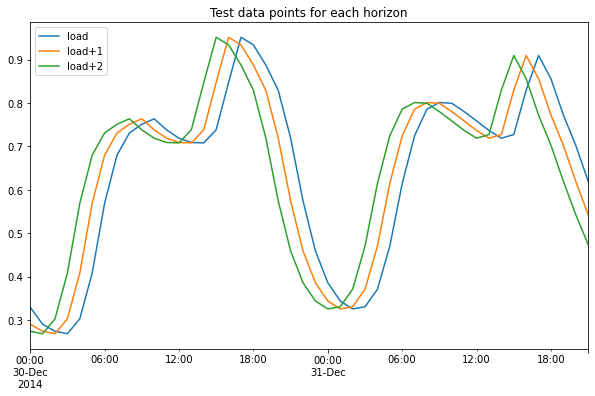

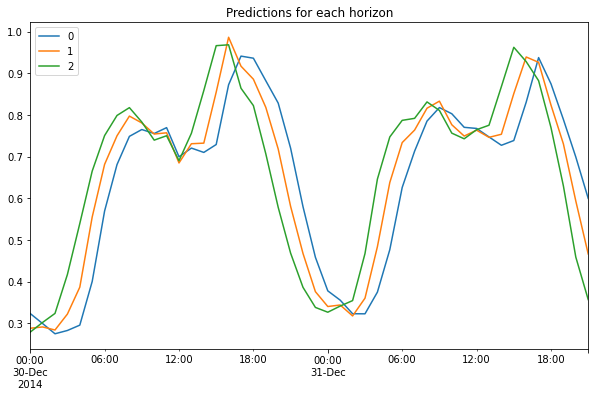

In [53]:
#$myVis - test data vs predictions
print(len(history), len(predictions))

test_shifted.plot(title="Test data points for each horizon")

df_yhat = pd.DataFrame(predictions, test_shifted.index)
df_yhat.plot(title="Predictions for each horizon");

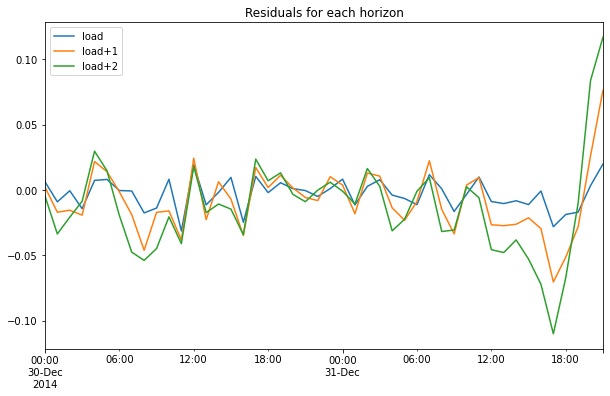

In [54]:
#$myVis residuals
df_residuals = test_shifted - df_yhat.values
df_residuals.plot(title="Residuals for each horizon");

##### Evaluate

In [56]:
eval_df = pd.DataFrame(
    predictions, columns=["t+" + str(t) for t in range(1, HORIZON + 1)]
)
eval_df["timestamp"] = test.index[0 : len(test.index) - HORIZON + 1]
eval_df = pd.melt(eval_df, id_vars="timestamp", value_name="prediction", var_name="h")
eval_df["actual"] = np.array(np.transpose(test_ts)).ravel()
eval_df[["prediction", "actual"]] = scaler.inverse_transform(
    eval_df[["prediction", "actual"]]
)
eval_df.head()

,timestamp,h,prediction,actual
0,2014-12-30 00:00:00,t+1,"3,008.94","3,023.00"
1,2014-12-30 01:00:00,t+1,"2,955.21","2,935.00"
2,2014-12-30 02:00:00,t+1,"2,900.29","2,899.00"
3,2014-12-30 03:00:00,t+1,"2,917.95","2,886.00"
4,2014-12-30 04:00:00,t+1,"2,946.57","2,963.00"


In [57]:
if HORIZON > 1:
    eval_df["APE"] = (eval_df["prediction"] - eval_df["actual"]).abs() / eval_df[
        "actual"
    ]
    print(eval_df.groupby("h")["APE"].mean())

h
t+1   0.01
t+2   0.01
t+3   0.02
Name: APE, dtype: float64


In [58]:
print(
    "One-step forecast MAPE: ",
    (
        mape(
            eval_df[eval_df["h"] == "t+1"]["prediction"],
            eval_df[eval_df["h"] == "t+1"]["actual"],
        )
    )
    * 100,
    "%",
)

One-step forecast MAPE:  0.5572523044743665 %


In [59]:
print(
    "Multi-step forecast MAPE: ",
    mape(eval_df["prediction"], eval_df["actual"]) * 100,
    "%",
)

Multi-step forecast MAPE:  1.147724755418393 %


## Xtra

##### Imports not used
from statsmodels.tsa.api import graphics  
from statsmodels.tsa.ar_model import ar_select_order (wiath AutoReg)

import seaborn as sns  
sns.set_style("darkgrid")  
sns.mpl.rc("figure", figsize=(16, 6))  


##### Deprecated legacy ARIMA 
$error: ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

note: The legacy ARIMA is deprecated. Use statsmodels.tsa.arima.model.ARIMA instead.
https://github.com/statsmodels/statsmodels/issues/4047from statsmodels.tsa.api import graphics

